In [9]:
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model

from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras import preprocessing 

import glob
import os, os.path
from os.path import basename
import pandas as pd
import matplotlib.pyplot as plt
import PIL.Image

from PIL import Image

In [14]:
classification_list =['apple', 'kaki', 'pumpkin', 'orange']
classification_list

['apple', 'kaki', 'pumpkin', 'orange']

In [15]:
BASE_DIR = '/home/aprameyo/Weekly_exercises/Week9/imageclassifier/imageclassifier/data/'


In [16]:
# define an image data generator
data_gen = preprocessing.image.ImageDataGenerator(
    # define the preprocessing function that should be applied to all images
    preprocessing_function=mobilenet_v2.preprocess_input,
    # fill_mode='nearest',
    # rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # horizontal_flip=True, 
    # zoom_range=0.2,
    # shear_range=0.2    
)

In [17]:
# a generator that returns batches of X and y arrays
train_data_gen = data_gen.flow_from_directory(
        directory=BASE_DIR,
        class_mode="categorical",
        classes=classification_list,
        batch_size=135,
        target_size=(224, 224)
)

Found 404 images belonging to 4 classes.


In [18]:
# load in all images at once
xtrain, ytrain = next(train_data_gen)
xtrain.shape, ytrain.shape

((135, 224, 224, 3), (135, 4))

## Load the model

In [19]:
base_model = mobilenet_v2.MobileNetV2(
    weights='imagenet', 
    alpha=0.35,         # specific parameter of this model, small alpha reduces the number of overall weights
    pooling='avg',      # applies global average pooling to the output of the last conv layer (like a flattening)
    include_top=False,  # we only want to have the base, not the final dense layers 
    input_shape=(224, 224, 3)
)

# freeze it!
base_model.trainable = False

2023424/2019640 [==============================] - 0s 0us/step


In [20]:
base_model.summary()

Model: "mobilenetv2_0.35_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 16) 432         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 16) 64          Conv1[0][0]                      
_______________________________________________________________________________

In [22]:
model = keras.Sequential()
model.add(base_model)
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(len(classification_list), activation='softmax'))
# have a look at the trainable and non-trainable params statistic
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_0.35_224 (Functi (None, 1280)              410208    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               128100    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 404       
Total params: 538,712
Trainable params: 128,504
Non-trainable params: 410,208
_________________________________________________________________


### Compile and train!

In [23]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=keras.losses.categorical_crossentropy,
              metrics=[keras.metrics.categorical_accuracy])

# observe the validation loss and stop when it does not improve after 3 iterations
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model.fit(xtrain, ytrain, 
          epochs=50, 
          verbose=2,
          batch_size=len(xtrain), 
          callbacks=[callback],
          # use 30% of the data for validation
          validation_split=0.3)

Epoch 1/50
1/1 - 1s - loss: 1.6937 - categorical_accuracy: 0.2021 - val_loss: 1.1380 - val_categorical_accuracy: 0.4878
Epoch 2/50
1/1 - 0s - loss: 1.0102 - categorical_accuracy: 0.6064 - val_loss: 0.9149 - val_categorical_accuracy: 0.6829
Epoch 3/50
1/1 - 0s - loss: 0.7759 - categorical_accuracy: 0.7234 - val_loss: 0.7508 - val_categorical_accuracy: 0.7073
Epoch 4/50
1/1 - 0s - loss: 0.6403 - categorical_accuracy: 0.7660 - val_loss: 0.6347 - val_categorical_accuracy: 0.7805
Epoch 5/50
1/1 - 0s - loss: 0.4999 - categorical_accuracy: 0.8404 - val_loss: 0.5290 - val_categorical_accuracy: 0.8537
Epoch 6/50
1/1 - 0s - loss: 0.3060 - categorical_accuracy: 0.9043 - val_loss: 0.4429 - val_categorical_accuracy: 0.8537
Epoch 7/50
1/1 - 0s - loss: 0.2799 - categorical_accuracy: 0.9149 - val_loss: 0.3718 - val_categorical_accuracy: 0.9024
Epoch 8/50
1/1 - 0s - loss: 0.2188 - categorical_accuracy: 0.9362 - val_loss: 0.3141 - val_categorical_accuracy: 0.9024
Epoch 9/50
1/1 - 1s - loss: 0.1312 - cat

In [62]:
path = '/home/aprameyo/Weekly_exercises/Week9/imageclassifier/imageclassifier/data/test/halloween-pumpkin-jls.png'
pic = keras.preprocessing.image.load_img(path,target_size=(224,224))

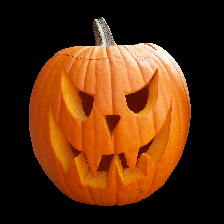

In [63]:
pic

In [64]:
numpy_image = keras.preprocessing.image.img_to_array(pic)
numpy_image.shape

(224, 224, 3)

In [65]:
image_batch = np.expand_dims(numpy_image, axis=0) # can also do with reshape
image_batch.shape

(1, 224, 224, 3)

In [66]:
processed_image = keras.applications.mobilenet_v2.preprocess_input(image_batch)

In [166]:
predictions = model.predict(processed_image)

predictions.round(3)[0,3]

0.0

In [175]:
predictions_list = []

for i in range(len(classification_list)):
    predictions_temp = [classification_list[i], predictions[0,i].round(3)]
    #print('test')
    predictions_list.append(predictions_temp)
    
# using list comprehension 
listToStr = ' '.join([str(elem) for elem in predictions_list]) 
  
listToStr

"['apple', 0.0] ['kaki', 0.007] ['pumpkin', 0.993] ['orange', 0.0]"

In [155]:
predictions = np.array2string(predictions, precision=3, separator=', ', suppress_small=True)


In [159]:
predictions

'[[0.   ],\n [0.007],\n [0.993],\n [0.   ]]'

In [105]:
classification_list

['apple', 'kaki', 'pumpkin', 'orange']

In [106]:
dictionary = dict(zip(classification_list, predictions))
dictionary

{'apple': '[', 'kaki': '[', 'pumpkin': '0', 'orange': '.'}

## Save the model

In [68]:
model.save("model_mobilenet.h5")
print("Saved model to disk")

Saved model to disk


In [70]:
# load, create and compile model

network = load_model("model_mobilenet.h5")
network.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_0.35_224 (Functi (None, 1280)              410208    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               128100    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 404       
Total params: 538,712
Trainable params: 128,504
Non-trainable params: 410,208
_________________________________________________________________


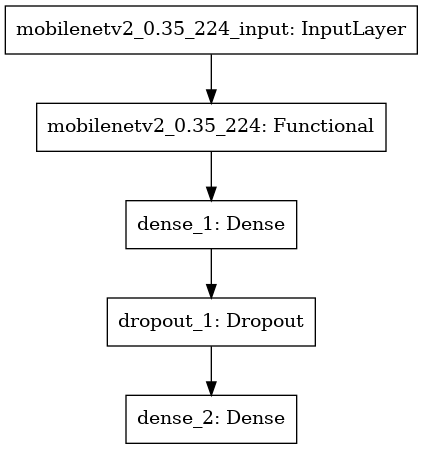

In [72]:
from IPython.display import SVG
from tensorflow.keras.utils import plot_model

plot_model(network,
   to_file='model_mobilenet.png',
   show_shapes=False,
   show_layer_names=True,
   rankdir='TB', expand_nested=False, dpi=96
)